In [1]:
import flirt.with_
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix,precision_score,recall_score,accuracy_score

/home/aaru/MTP/jup/lib/python3.8/site-packages/flirt/acc/feature_calculation.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


### Data Description

- Used windows_length = 10 and window_step_size = 10. This means the model will give predictions in a window of 10 seconds and all windows are non-overlapping.

- We have taken hrv,eda,acc data from empatica for processing. We have excluded TEMP data as change in it cannot be detected in 10s.

In [23]:
zip_file_path = "./Empatica/1659768236_A04B39.zip"
df = flirt.with_.empatica(zip_file_path,
                            window_length = 10,
                            window_step_size = 10,
                            hrv_features = True,
                            eda_features = True,
                            acc_features = True)
data = df
data.head(10)

EDA features: 100%|████████████████████████████| 93/93 [00:00<00:00, 732.48it/s]
/tmp/ipykernel_9649/3071368833.py:2: UserWarning: phasic_entropy contains more than 5% (actual: 58.06%) nan, inf, or -inf values. We recommend to delete this feature column.
  df = flirt.with_.empatica(zip_file_path,
ACC features: 100%|████████████████████████████| 94/94 [00:00<00:00, 542.22it/s]


,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,acc_l2_n_above_mean,acc_l2_n_below_mean,acc_l2_n_sign_changes,acc_l2_iqr,acc_l2_iqr_5_95,acc_l2_pct_5,acc_l2_pct_95,acc_l2_entropy,acc_l2_perm_entropy,acc_l2_svd_entropy
2022-08-06 06:44:06+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,107.0,213.0,0.0,3.931986,32.452277,50.071798,82.524075,5.755582,0.998384,0.430579
2022-08-06 06:44:16+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.0,174.0,0.0,9.938644,34.967775,48.522018,83.489793,5.751492,0.997924,0.502343
2022-08-06 06:44:26+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,241.0,0.0,3.554148,31.154139,54.434703,85.588842,5.755983,0.996832,0.434178
2022-08-06 06:44:36+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,128.0,192.0,0.0,2.489876,16.650683,55.206359,71.857042,5.760399,0.997924,0.369637
2022-08-06 06:44:46+00:00,7.0,681.328125,679.687500,91.40625,26.729747,28.613740,0.950000,9.500000,3.900000,40.0,...,145.0,175.0,0.0,4.635753,20.305851,55.538696,75.844547,5.763423,0.999993,0.299042
2022-08-06 06:44:56+00:00,0.0,655.546875,653.645833,83.59375,27.304261,28.902151,0.783333,7.833333,3.566667,40.0,...,139.0,181.0,0.0,5.830603,28.634535,50.977416,79.611950,5.757937,0.999131,0.418870
2022-08-06 06:45:06+00:00,0.0,629.765625,627.604167,75.78125,27.878775,29.190562,0.616667,6.166667,3.233333,40.0,...,172.0,148.0,0.0,3.664132,9.531143,58.875712,68.406854,5.767263,0.997924,0.200483
2022-08-06 06:45:16+00:00,0.0,603.984375,601.562500,67.96875,28.453289,29.478973,0.450000,4.500000,2.900000,40.0,...,138.0,182.0,0.0,4.797168,22.418507,54.662587,77.081094,5.761759,0.999993,0.342026
2022-08-06 06:45:26+00:00,0.0,578.203125,575.520833,60.15625,29.027802,29.767384,0.283333,2.833333,2.566667,40.0,...,162.0,158.0,0.0,5.360243,21.801564,53.087656,74.889219,5.762935,0.999993,0.307233
2022-08-06 06:45:36+00:00,1.5,552.421875,549.479167,52.34375,29.602316,30.055795,0.116667,1.166667,2.233333,40.0,...,162.0,158.0,0.0,3.186067,8.774102,59.613756,68.387858,5.767399,0.997924,0.183715


In [24]:
list(data)

['num_ibis',
 'hrv_mean_nni',
 'hrv_median_nni',
 'hrv_range_nni',
 'hrv_sdsd',
 'hrv_rmssd',
 'hrv_nni_50',
 'hrv_pnni_50',
 'hrv_nni_20',
 'hrv_pnni_20',
 'hrv_cvsd',
 'hrv_sdnn',
 'hrv_cvnni',
 'hrv_mean_hr',
 'hrv_min_hr',
 'hrv_max_hr',
 'hrv_std_hr',
 'hrv_total_power',
 'hrv_vlf',
 'hrv_lf',
 'hrv_hf',
 'hrv_lf_hf_ratio',
 'hrv_lfnu',
 'hrv_hfnu',
 'hrv_mean',
 'hrv_std',
 'hrv_min',
 'hrv_max',
 'hrv_ptp',
 'hrv_sum',
 'hrv_energy',
 'hrv_skewness',
 'hrv_kurtosis',
 'hrv_peaks',
 'hrv_rms',
 'hrv_lineintegral',
 'hrv_n_above_mean',
 'hrv_n_below_mean',
 'hrv_n_sign_changes',
 'hrv_iqr',
 'hrv_iqr_5_95',
 'hrv_pct_5',
 'hrv_pct_95',
 'hrv_entropy',
 'hrv_perm_entropy',
 'hrv_svd_entropy',
 'eda_tonic_mean',
 'eda_tonic_std',
 'eda_tonic_min',
 'eda_tonic_max',
 'eda_tonic_ptp',
 'eda_tonic_sum',
 'eda_tonic_energy',
 'eda_tonic_skewness',
 'eda_tonic_kurtosis',
 'eda_tonic_peaks',
 'eda_tonic_rms',
 'eda_tonic_lineintegral',
 'eda_tonic_n_above_mean',
 'eda_tonic_n_below_mean',

In [25]:
data = df

### Data Cleaning

- Initial rows have NAN value in all HRV extracted features. This is due to the reason that data for HRV is not measured by the empatica band for some initial time

- Remove initial rows that have NAN values in HRV extracted features

- For some features the measured value comes as -infity. We have remove those features from our data as in most of the rows the feature is -infinity

In [26]:
# data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
# data.shape

data = data.dropna(axis=0)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data = data.dropna(axis=1)
data.shape


/tmp/ipykernel_9649/197174417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf], np.nan, inplace=True)


(90, 173)

In [27]:
data.tail(10)

,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,acc_l2_n_above_mean,acc_l2_n_below_mean,acc_l2_n_sign_changes,acc_l2_iqr,acc_l2_iqr_5_95,acc_l2_pct_5,acc_l2_pct_95,acc_l2_entropy,acc_l2_perm_entropy,acc_l2_svd_entropy
2022-08-06 06:58:06+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,159.0,161.0,0.0,4.000964,21.535537,52.510945,74.046483,5.761172,0.998384,0.357764
2022-08-06 06:58:16+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,102.0,218.0,0.0,5.414261,42.645882,47.321612,89.967494,5.751152,0.995509,0.431425
2022-08-06 06:58:26+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,103.0,217.0,0.0,3.364409,24.119714,54.991598,79.111312,5.761728,0.999648,0.360156
2022-08-06 06:58:36+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,144.0,176.0,0.0,10.192748,41.701215,45.751487,87.452702,5.752390,0.999993,0.433614
2022-08-06 06:58:46+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,144.0,176.0,0.0,6.617549,34.516930,47.894466,82.411396,5.753439,0.998384,0.477925
2022-08-06 06:58:56+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,133.0,187.0,0.0,7.559281,24.786864,53.908708,78.695572,5.759050,0.999648,0.429850
2022-08-06 06:59:06+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,127.0,193.0,0.0,6.134297,23.628419,54.560038,78.188456,5.760524,0.999648,0.410641
2022-08-06 06:59:16+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,163.0,157.0,0.0,5.611009,15.894786,54.845222,70.740008,5.765122,0.997924,0.309258
2022-08-06 06:59:26+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,126.0,194.0,0.0,3.052436,12.622347,57.642865,70.265212,5.765419,0.999821,0.296154
2022-08-06 06:59:36+00:00,0.0,492.1875,484.375,31.25,20.728905,20.963137,0.0,0.0,2.0,33.333333,...,12.0,12.0,0.0,1.098777,5.712335,60.632671,66.345006,3.177590,0.998364,0.138398


In [28]:
list(data[data == -np.inf].count())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [29]:
list(data)

['num_ibis',
 'hrv_mean_nni',
 'hrv_median_nni',
 'hrv_range_nni',
 'hrv_sdsd',
 'hrv_rmssd',
 'hrv_nni_50',
 'hrv_pnni_50',
 'hrv_nni_20',
 'hrv_pnni_20',
 'hrv_cvsd',
 'hrv_sdnn',
 'hrv_cvnni',
 'hrv_mean_hr',
 'hrv_min_hr',
 'hrv_max_hr',
 'hrv_std_hr',
 'hrv_total_power',
 'hrv_vlf',
 'hrv_lf',
 'hrv_hf',
 'hrv_lf_hf_ratio',
 'hrv_lfnu',
 'hrv_hfnu',
 'hrv_mean',
 'hrv_std',
 'hrv_min',
 'hrv_max',
 'hrv_ptp',
 'hrv_sum',
 'hrv_energy',
 'hrv_skewness',
 'hrv_kurtosis',
 'hrv_peaks',
 'hrv_rms',
 'hrv_lineintegral',
 'hrv_n_above_mean',
 'hrv_n_below_mean',
 'hrv_n_sign_changes',
 'hrv_iqr',
 'hrv_iqr_5_95',
 'hrv_pct_5',
 'hrv_pct_95',
 'hrv_entropy',
 'hrv_perm_entropy',
 'hrv_svd_entropy',
 'eda_tonic_mean',
 'eda_tonic_std',
 'eda_tonic_min',
 'eda_tonic_max',
 'eda_tonic_ptp',
 'eda_tonic_sum',
 'eda_tonic_energy',
 'eda_tonic_skewness',
 'eda_tonic_kurtosis',
 'eda_tonic_peaks',
 'eda_tonic_rms',
 'eda_tonic_lineintegral',
 'eda_tonic_n_above_mean',
 'eda_tonic_n_below_mean',

In [ ]:
#Features that are dropped because of infinity value
set(df)-set(data)

### Dimension Reduction
- First we have normalized the data and further we have PCA analysis
- We have taken first two principal component from PCA (can be extended)
- 

In [30]:
scale = StandardScaler()
transformed_data = scale.fit_transform(data)

In [31]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(transformed_data)

In [32]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.22225013, 0.33239178])

In [34]:
principalDf.head(10)

,principal component 1,principal component 2
0,5.528431,-9.815833
1,15.738430,-11.877205
2,-1.443681,-4.870356
3,4.621411,-6.173465
4,4.501022,-4.643763
5,-1.937943,0.238937
6,-1.963767,1.207954
7,-2.389198,-0.090128
8,-4.659162,-3.310981
9,-3.840241,-4.455781


Text(0, 0.5, 'Principal Component 2')

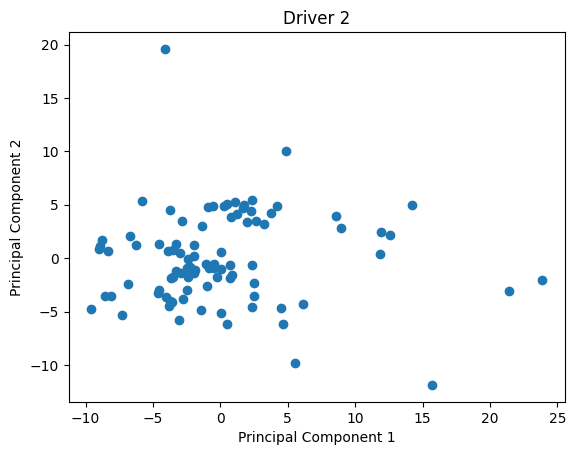

In [35]:
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.title("Driver 2") #title
plt.xlabel("Principal Component 1") #x label
plt.ylabel("Principal Component 2") #y label

### Stress Estimation

- We used KMeans++ unsupervised clustering algorithm to form clusters of data
- Clustered data into two classes with label stress and No stress.
- KMeans++ does not used random intialization and have O(log k) approximation from optimum clusters

In [36]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [37]:
y_km = km.fit_predict(principalDf)
y_km

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0], dtype=int32)

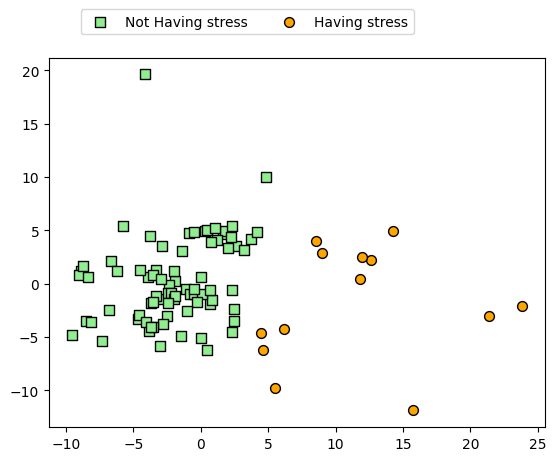

In [38]:
plt.scatter(
    principalDf[y_km == 0]['principal component 1'], principalDf[y_km == 0]['principal component 2'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='Not Having stress'
)

plt.scatter(
    principalDf[y_km == 1]['principal component 1'], principalDf[y_km == 1]['principal component 2'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='Having stress'
)
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)

### Evaluation
- Manually annotated data from videos and compared it with Kmeans++ cluster
- This parts needs updation. Have to do manual annotation by a professional


In [83]:
d3 = np.array([0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0])
y = y_km[13:13+54]
precision_recall_fscore_support(d3,y)
# y_km

(array([0.33333333, 0.0625    ]),
 array([0.04255319, 0.42857143]),
 array([0.0754717 , 0.10909091]),
 array([47,  7]))

In [84]:
accuracy_score(d3,y)

0.09259259259259259

In [85]:
# d4 = np.array([0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1])
# y = y_km[16:16+42]
# precision_recall_fscore_support(d4,y)

In [86]:
# accuracy_score(d4,y)

In [87]:
cf_matrix = confusion_matrix(d3, y)
print(cf_matrix)

[[ 2 45]
 [ 4  3]]


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

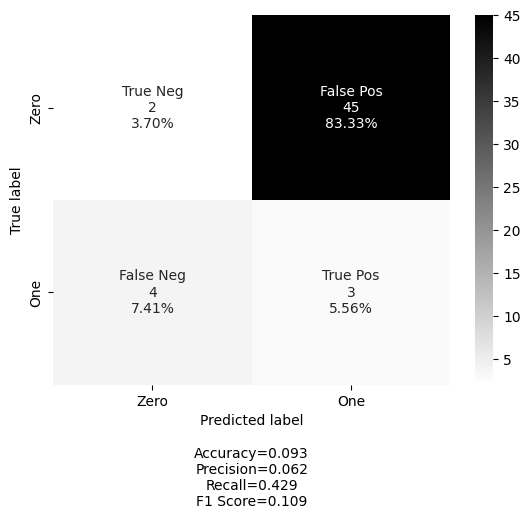

In [89]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')